In [0]:
# Year of clinical trial
ct_year = str(2021)

In [0]:
fileroot = "clinicaltrial_" + ct_year
clinicaltrial_filepath = "/FileStore/tables/clinicaltrial_" + ct_year + ".csv"

import os
os.environ ['fileroot'] = fileroot

In [0]:
%sh
rm /tmp/$fileroot.csv
rm /tmp/$fileroot.zip

rm: cannot remove '/tmp/clinicaltrial_2021.csv': No such file or directory
rm: cannot remove '/tmp/clinicaltrial_2021.zip': No such file or directory


In [0]:
# Clean the DBFS from the contents that the notebook needs to create again

dbutils.fs.rm("/FileStore/tables/" + fileroot + ".csv", True)
dbutils.fs.rm("/FileStore/tables/pharma.csv", True)

Out[4]: False

In [0]:
dbutils.fs.cp("/FileStore/tables/" + fileroot + ".zip", "file:/tmp/")
dbutils.fs.cp("/FileStore/tables/pharma.zip", "file:/tmp/")

Out[5]: True

In [0]:
%sh
unzip -d /tmp /tmp/$fileroot.zip
unzip -d /tmp /tmp/pharma.zip

Archive:  /tmp/clinicaltrial_2021.zip
  inflating: /tmp/clinicaltrial_2021.csv  
Archive:  /tmp/pharma.zip
  inflating: /tmp/pharma.csv         


In [0]:
dbutils.fs.mv("file:/tmp/" + fileroot + ".csv", "/FileStore/tables/" + fileroot + ".csv", True )

Out[7]: True

In [0]:
dbutils.fs.mv("file:/tmp/pharma.csv", "/FileStore/tables/pharma.csv", True )

Out[8]: True

In [0]:
dbutils.fs.ls("/FileStore/tables/")

Out[9]: [FileInfo(path='dbfs:/FileStore/tables/FaultDataset-1.csv', name='FaultDataset-1.csv', size=1703184, modificationTime=1678127211000),
 FileInfo(path='dbfs:/FileStore/tables/FaultDataset-2.csv', name='FaultDataset-2.csv', size=1703184, modificationTime=1678127478000),
 FileInfo(path='dbfs:/FileStore/tables/FaultDataset-3.csv', name='FaultDataset-3.csv', size=1703184, modificationTime=1678128014000),
 FileInfo(path='dbfs:/FileStore/tables/FaultDataset-4.csv', name='FaultDataset-4.csv', size=1703184, modificationTime=1678128595000),
 FileInfo(path='dbfs:/FileStore/tables/FaultDataset-5.csv', name='FaultDataset-5.csv', size=1703184, modificationTime=1678132279000),
 FileInfo(path='dbfs:/FileStore/tables/FaultDataset.csv', name='FaultDataset.csv', size=1703184, modificationTime=1678127097000),
 FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data.csv', name='Occupancy_Detection_Data.csv', size=50968, modificationTime=1677962483000),
 FileInfo(path='dbfs:/FileStore/tables/a

In [0]:
ct_year

Out[10]: '2021'

In [0]:
from pyspark.sql import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

In [0]:
# A method for creating rdds
def rddcreator(file_name):  
    created_rdd=sc.textFile(file_name) 
    firstrow = created_rdd.first()
    # removing the header
    rest_of_rdd = created_rdd.filter(lambda row: row!=firstrow)
    return rest_of_rdd

In [0]:
clinicaltrial_rdd = rddcreator(clinicaltrial_filepath)

In [0]:
clinicaltrial_rdd.take(5)

Out[14]: ['NCT02758028|The University of Hong Kong|Recruiting|Aug 2005|Nov 2021|Interventional|Apr 2016||',
 'NCT02751957|Duke University|Completed|Jul 2016|Jul 2020|Interventional|Apr 2016|Autistic Disorder,Autism Spectrum Disorder|',
 'NCT02758483|Universidade Federal do Rio de Janeiro|Completed|Mar 2017|Jan 2018|Interventional|Apr 2016|Diabetes Mellitus|',
 'NCT02759848|Istanbul Medeniyet University|Completed|Jan 2012|Dec 2014|Observational|May 2016|Tuberculosis,Lung Diseases,Pulmonary Disease|',
 'NCT02758860|University of Roma La Sapienza|Active, not recruiting|Jun 2016|Sep 2020|Observational [Patient Registry]|Apr 2016|Diverticular Diseases,Diverticulum,Diverticulosis|']

In [0]:
pharma_rdd = spark.read.option("header","true").option("inferSchema", "true").csv("/FileStore/tables/pharma.csv").rdd

In [0]:
pharma_rdd.take(5)

Out[16]: [Row(Company='Abbott Laboratories', Parent_Company='Abbott Laboratories', Penalty_Amount='$5,475,000', Subtraction_From_Penalty='$0', Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting='$5,475,000', Penalty_Year=2013, Penalty_Date=20131227, Offense_Group='government-contracting-related offenses', Primary_Offense='False Claims Act and related', Secondary_Offense='kickbacks and bribery', Description="Abbott Laboratories agreed to $5.475 million to resolve allegations that it violated the False Claims Act by paying kickbacks to induce doctors to implant the company's carotid, biliary and peripheral vascular products.", Level_of_Government='federal', Action_Type='agency action', Agency='Justice Department Civil Division', Civil/Criminal='civil', Prosecution_Agreement=None, Court=None, Case_ID=None, Private_Litigation_Case_Title=None, Lawsuit_Resolution=None, Facility_State=None, City=None, Address=None, Zip=None, NAICS_Code=None, NAICS_Translation=None, HQ_Country_of_Parent

In [0]:
# Question 1. To find the number of Distinct studies

In [0]:
clinicaltrial_rdd.distinct().count()

Out[18]: 387261

In [0]:
# Splitting the clinical trial data by delimeter
clinicaltrial_rdd = clinicaltrial_rdd.map(lambda line: line.split('|'))

In [0]:
# Question 2. To list all the types and frequency

In [0]:
#Types of studies and their frequencies
types_rdd = clinicaltrial_rdd.map(lambda line: (line[5], 1))
types_rdd.take(5)

Out[21]: [('Interventional', 1),
 ('Interventional', 1),
 ('Interventional', 1),
 ('Observational', 1),
 ('Observational [Patient Registry]', 1)]

In [0]:
types_rdd = types_rdd.reduceByKey(lambda accumulation,current: accumulation + current).sortBy(lambda row: -row[1], ascending=True)

In [0]:
# Result
types_rdd.collect()

Out[23]: [('Interventional', 301472),
 ('Observational', 77540),
 ('Observational [Patient Registry]', 8180),
 ('Expanded Access', 69)]

In [0]:
# Question 3. Top 5 conditions with their frequencies

In [0]:
conditions_rdd = clinicaltrial_rdd.flatMap(lambda line: line[7].split(",")).map(lambda line: (line,1)).filter(lambda line: line[0])

In [0]:
conditions_rdd.take(5)

Out[26]: [('Autistic Disorder', 1),
 ('Autism Spectrum Disorder', 1),
 ('Diabetes Mellitus', 1),
 ('Tuberculosis', 1),
 ('Lung Diseases', 1)]

In [0]:
# Result
conditions_rdd = conditions_rdd.reduceByKey(lambda accumulation,current: accumulation + current).sortBy(lambda row: -row[1]) 
conditions_rdd.take(5)

Out[27]: [('Carcinoma', 13389),
 ('Diabetes Mellitus', 11080),
 ('Neoplasms', 9371),
 ('Breast Neoplasms', 8640),
 ('Syndrome', 8032)]

In [0]:
# Question 4. 10 most common sponsors that are not pharmaceutical companies, along with the number of clinical trials they have sponsored.

In [0]:
sponsor_rdd = clinicaltrial_rdd.map(lambda line:(line[1], line[2])) 
parent_rdd = pharma_rdd.map(lambda line: (line.Parent_Company,0))

In [0]:
parent_rdd.take(5)

Out[30]: [('Abbott Laboratories', 0),
 ('AbbVie', 0),
 ('AbbVie', 0),
 ('Abbott Laboratories', 0),
 ('Johnson & Johnson', 0)]

In [0]:
sponsor_rdd.take(5)

Out[31]: [('The University of Hong Kong', 'Recruiting'),
 ('Duke University', 'Completed'),
 ('Universidade Federal do Rio de Janeiro', 'Completed'),
 ('Istanbul Medeniyet University', 'Completed'),
 ('University of Roma La Sapienza', 'Active, not recruiting')]

In [0]:
pharma_sponsor_rdd = sponsor_rdd.leftOuterJoin(parent_rdd).filter(lambda line: line[1][1]==None and line[1][0]!="Active") 
pharma_sponsor_rdd = pharma_sponsor_rdd.map(lambda line:(line[0],1)).reduceByKey(lambda accumulation,current: accumulation + current).sortBy(lambda row: -row[1])

In [0]:
# Result
pharma_sponsor_rdd.take(10)

Out[33]: [('National Cancer Institute (NCI)', 3218),
 ('M.D. Anderson Cancer Center', 2414),
 ('Assistance Publique - Hôpitaux de Paris', 2369),
 ('Mayo Clinic', 2300),
 ('Merck Sharp & Dohme Corp.', 2243),
 ('Assiut University', 2154),
 ('Novartis Pharmaceuticals', 2088),
 ('Massachusetts General Hospital', 1971),
 ('Cairo University', 1928),
 ('Hoffmann-La Roche', 1828)]

In [0]:
# Question 5. Number of completed studies each month in a given year

In [0]:
completedstudies_rdd = clinicaltrial_rdd.filter(lambda line: line[2]=="Completed" and ct_year in line[4]).map(lambda line:(line[4].split(" ")[0],1))
completedstudies_rdd = completedstudies_rdd.reduceByKey(lambda accumulation,current: accumulation + current)

In [0]:
# Result
completedstudies_rdd.collect()

Out[36]: [('May', 984),
 ('Jan', 1131),
 ('Jun', 1094),
 ('Mar', 1227),
 ('Feb', 934),
 ('Aug', 700),
 ('Apr', 967),
 ('Jul', 819),
 ('Oct', 187),
 ('Sep', 528)]

In [0]:
months_dictionary = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12}

In [0]:
# Result
completedstudies_rdd = completedstudies_rdd.sortBy(lambda line: months_dictionary.get(line[0])) 
completedstudies_rdd.collect()

Out[38]: [('Jan', 1131),
 ('Feb', 934),
 ('Mar', 1227),
 ('Apr', 967),
 ('May', 984),
 ('Jun', 1094),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

In [0]:
completion_months = completedstudies_rdd.map(lambda row: row[0]).collect()
frequency = completedstudies_rdd.map(lambda row: row[1]).collect()

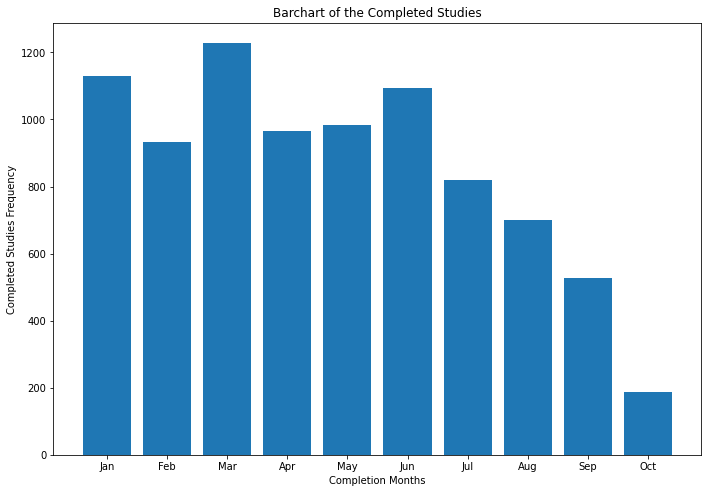

In [0]:
# Visualize
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.bar(completion_months,frequency)

plt.xlabel("Completion Months")
plt.ylabel("Completed Studies Frequency")
plt.title("Barchart of the Completed Studies")

plt.show()

FURTHER ANALYSIS - Find the top 10 distribution of study phases for completed clinical trials.

In [0]:
completed_rdd = clinicaltrial_rdd.filter(lambda line: line[2] == "Completed")

In [0]:
phases_rdd = completed_rdd.map(lambda line: (line[6], 1))
phases_count = phases_rdd.reduceByKey(lambda accumulation, current: accumulation + current)

In [0]:
phases_count_sorted = phases_count.sortBy(lambda row: -row[1])

In [0]:
phases_count_top10= phases_count_sorted.take(10)

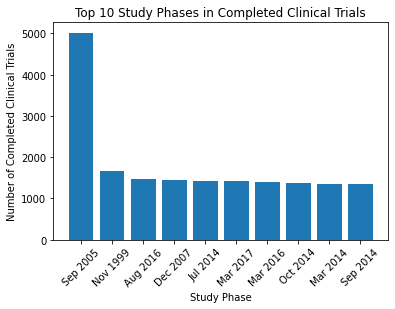

In [0]:
import matplotlib.pyplot as plt

# Extract data from the phases_count_results list
phases = [row[0] for row in phases_count_top10]
counts = [row[1] for row in phases_count_top10]

# Create the bar chart
plt.bar(phases, counts)
plt.xlabel("Study Phase")
plt.ylabel("Number of Completed Clinical Trials")
plt.title("Top 10 Study Phases in Completed Clinical Trials")
plt.xticks(rotation=45)
plt.show()